# CHAPTER4 모델훈련

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 선형회귀

$\hat{y} = \theta_0 + \theta_1x_1 + \theta_2x_2 + … + \theta_nx_n$

- $\hat{y}$ : 예측값
- n : 특성의 수
- $x_i$ : i번째 특성값
- $\theta_j$ : j번째 모델 파라미터

모델을 훈련시킨다 = 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정한다<br><br>
모델이 훈련 데이터에 얼마나 잘 들어맞나?<br>
= 성능 측정 지표 RMSE를 최소화하는 ϴ 찾기

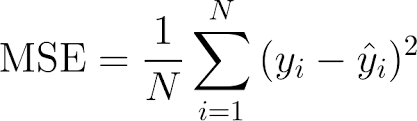

### 정규방정식

- 비용 함수를 최소화하는 $\theta$값을 찾기 위한 공식

$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$

- $\hat{\theta}$ : 비용 함수를 최소화하는 $\theta$값
- $y$ : $y^{(1)}$부터 $y^{(m)}$까지 포함하는 타깃 벡터

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

그림 저장: generated_data_plot


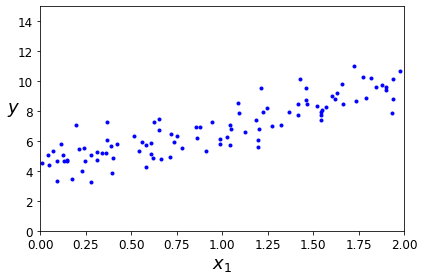

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

이 데이터를 생성하기 위해 사용한 함수는 $y = 4+3x_1+α$<br>
$\theta_0 = 4$, $\theta_1 = 3$을 기대하였으나 잡음(α) 때문에 약 4.215, 2.770이 나옴

$\hat{y} = \mathbf{X} \boldsymbol{\hat{\theta}}$

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

그림 저장: linear_model_predictions_plot


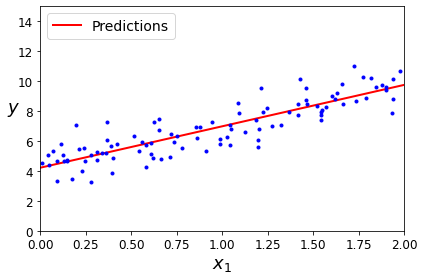

In [8]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

### 계산복잡도

- 정규방정식의 경우 $(n+1)(n+1)$ 크기가 되는 $X^TX$의 역행렬 계산
- 역행렬을 계산하는 계산 복잡도 : $O(n^{2.4})$ ~ $O(n^3)$
- LinearRegression 클래스가 사용하는 SVD 방법의 계산 복잡도 : $O(n^2)$
- 정규방정식과 SVD 모두 특성 수가 많아지면 매우 느려짐

## 경사하강법

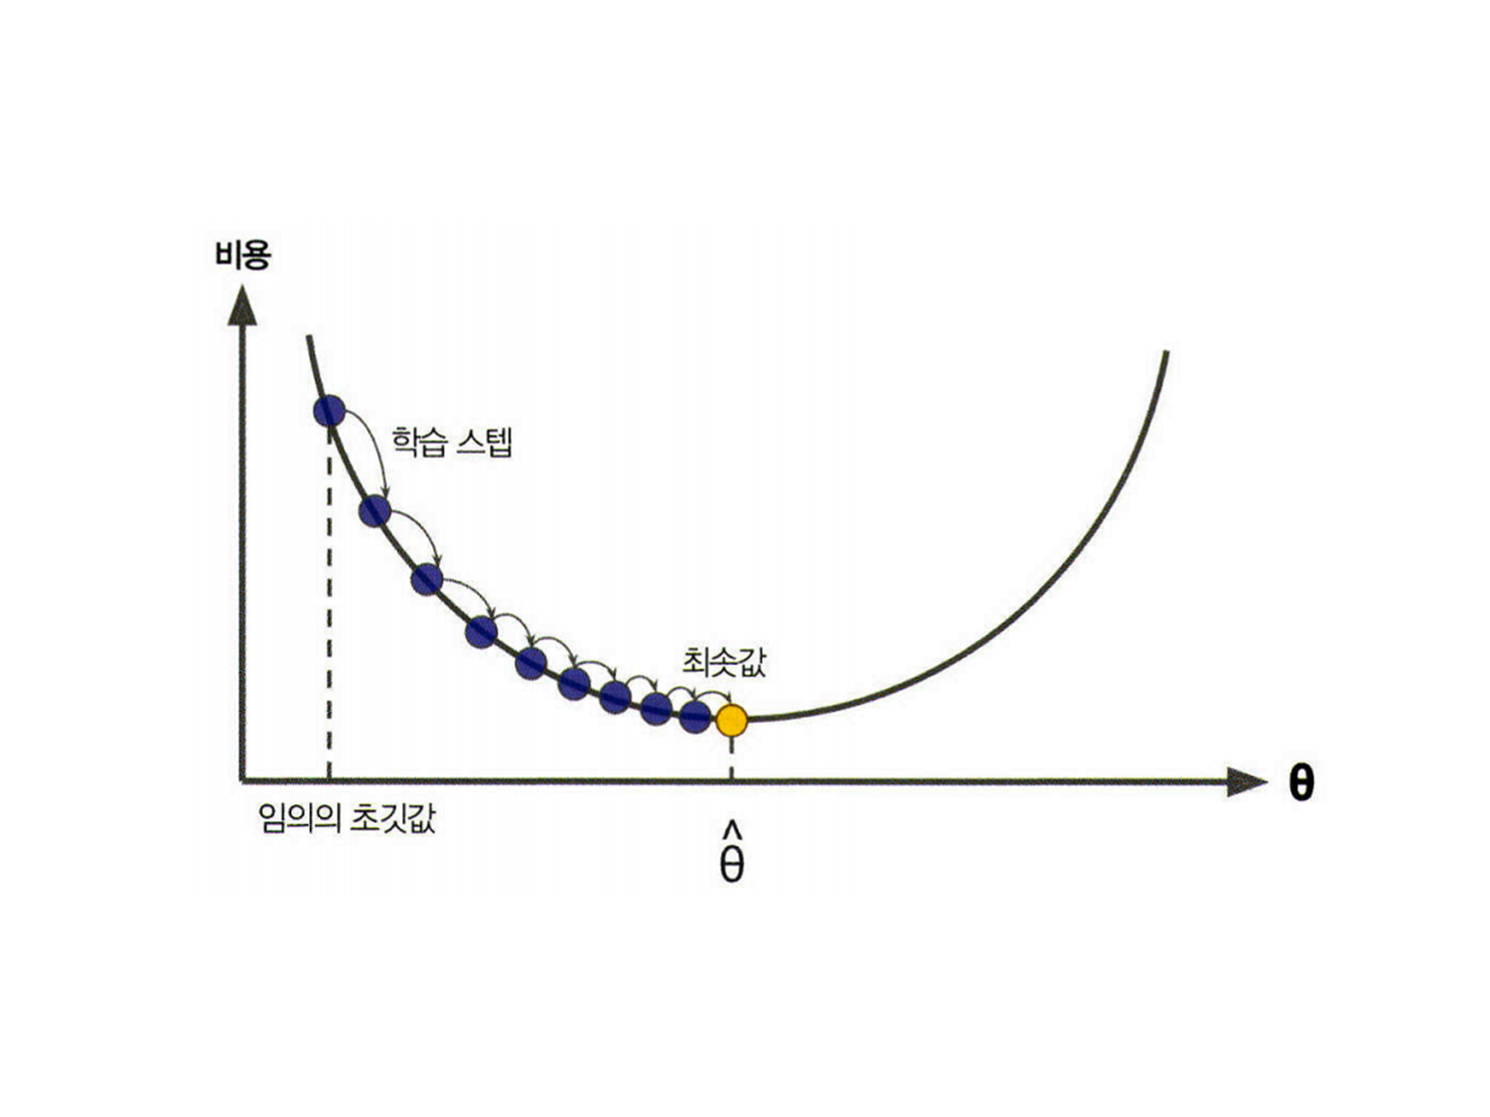

- $\theta$를 임의의 값으로 시작해(무작위 초기화) 한 번에 조금씩 비용 함수(ex MSE)가 감소되는 방향으로 진행해 알고리즘이 최솟값에 수렴할 때까지 점진적으로 향상시킴
- 중요한 파라미터는 스텝의 크기, **학습률** 하이퍼파라미터

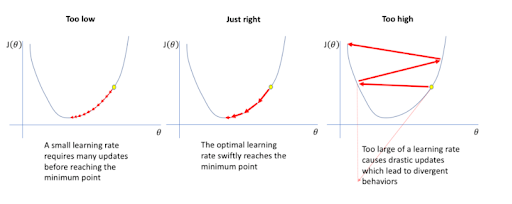

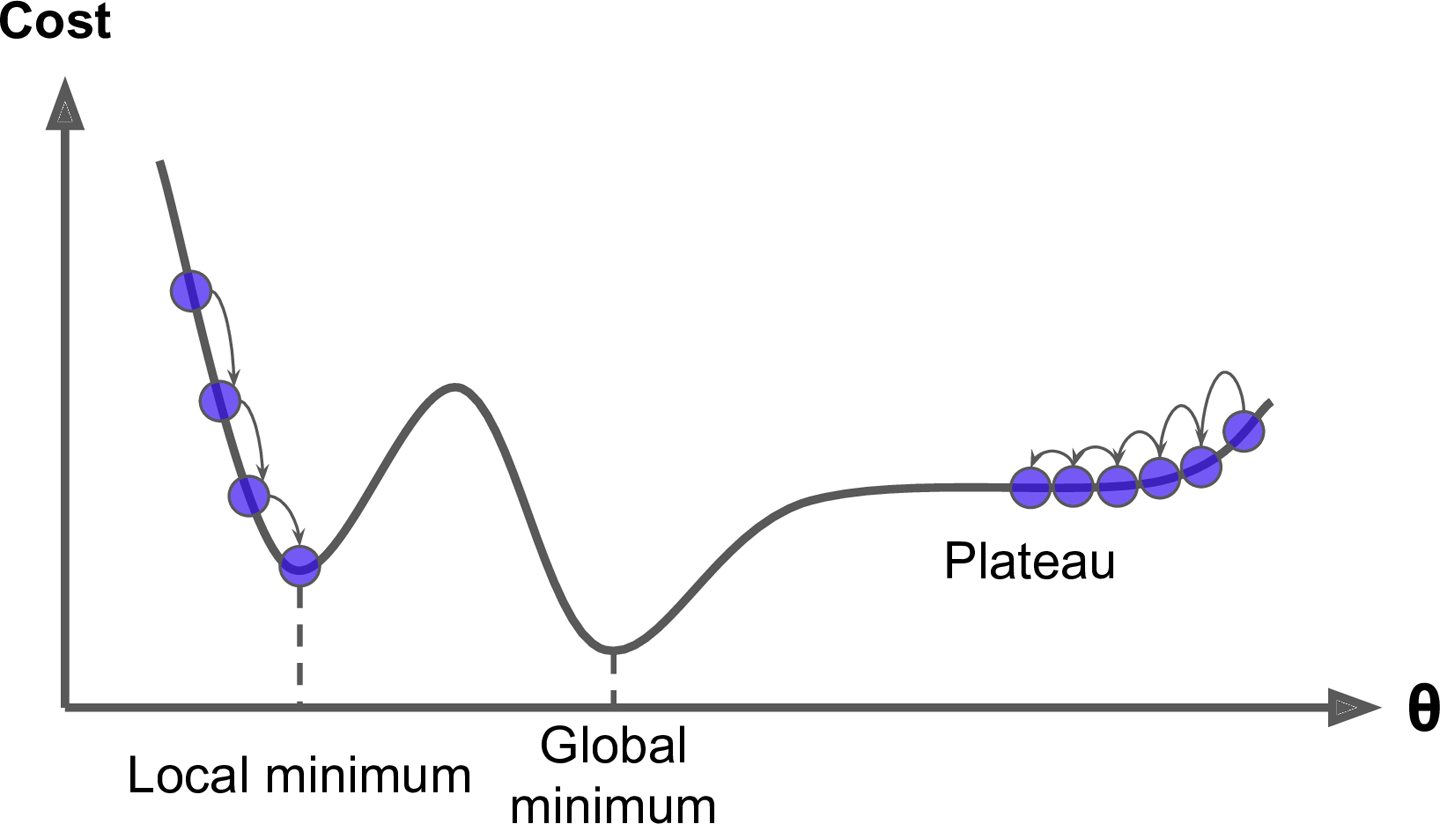

- 모든 비용 함수가 매끈한 그릇 같지는 X
- 무작위 초기화 때문에 알고리즘이 왼쪽에서 시작하면 전역 최솟값(Global minimum)보다 덜 좋은 지역 최솟값(Local minimum)에 수렴
- 알고리즘이 오른쪽에서 시작하면 평탄한 지역을 지나기 위해 시간 오래 걸리고 일찍 멈추게 되어 전역 최솟값(Global minimum)에 도달하지 못함

- 선형 회귀를 위한 MSE 비용 함수는 볼록 함수이므로 Local minimum이 없고 하나의 Global minimum만 있음

- 경사 하강법을 사용할 때는 반드시 모든 특성이 같은 스케일을 갖도록(ex StandardScaler) 해야 함

### 배치 경사 하강법

- 각 모델 파라미터 $\theta_j$에 대해 비용 함수의 그레디언트를 계산해야함
- 이를 편도함수(partial derivative)


**식 4-6: 비용 함수의 그레이디언트 벡터**

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$

- 매 경사 하강법 스텝에서 전체 훈련 세트 X에 대해 계산함
- 매 스텝에서 훈련 데이터 전체를 사용하므로 매우 큰 훈련 세트에서는 아주 느림
- 하지만 정규방정식이나 SVD 분해보다 경사 하강법을 사용하는 편이 훨씬 빠름

**식 4-7: 경사 하강법의 스텝**

$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
$

- $\eta$ : 학습률

In [12]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [13]:
theta

array([[4.21509616],
       [2.77011339]])

- 정규방정식과 결과값 동일

In [14]:
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

- 3가지 다른 학습률에 따라 진행한 경사 하강법의 스텝 처음 10개 시각화

In [15]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

그림 저장: gradient_descent_plot


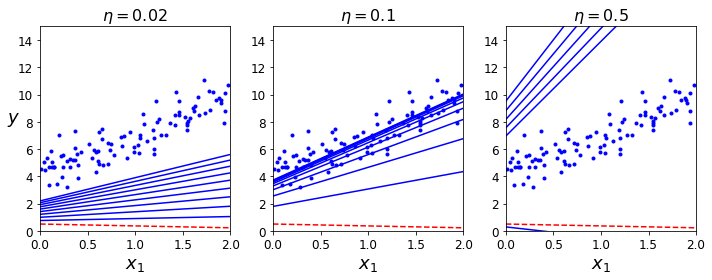

In [16]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

- 0.02일 때는 학습률이 너무 낮음. 시간이 오래 걸릴 것
- 0.1일 때는 적당. 이미 최적점에 수렵
- 0.5일 때는 학습률이 너무 높음. 최적점에서 더 멀어져 발산

- 적절한 학습률 찾기?
- 그리드 탐색을 이용하되 너무 오래 걸리는 모델을 막기 위해 반복 횟수 제한
- 반복 횟수?
- 반복 횟수를 아주 크게 지정하고 크레디언트 벡터가 아주 작아지면(=어떤 값 ε(허용오차)보다 작아지면) 경사 하강법이 거의 최솟값에 도달한 것이므로 알고리즘 중지

### 확률적 경사 하강법

- 배치 경사 하강법의 가장 큰 문제 : 매 스텝에서 전체 훈련 세트를 사용해 그레디언트 계산
- 따라서 훈련 세트가 커지면 매우 느려짐

- 확률적 경사 하강법은 매 스텝에서 한 개의 샘플을 무작위로 선택 후 그 하나의 샘플에 대한 그레디언트 계산
- 매 반복에서 다뤄야 할 데이터가 매우 적기 때문에 알고리즘이 확실히 훨씬 빠름
- 매 반복에서 하나의 샘플만 메모리에 있으면 되므로 매우 큰 훈련 세트도 훈련시킬 수 있음

- 반면 확률적이기 때문에 배치 경사 하강법보다 훨씬 불안정
- 비용 함수가 최솟값에 다다를 때까지 부드럽게 감소하지 않고 위아래로 요동치면서 평균적으로 감소
- 알고리즘이 멈출 때 좋은 파라미터가 구해지겠지만 최적치는 아님
- 비용 함수가 매우 불규칙할 경우 Local minimum을 건너뛸 수 있도록 도와주므로 배치 경사 하강법보다 Global minimum을 찾을 가능성이 높음

- 해결하는 방법 : 학습률을 점진적으로 감소시키는 것
- 시작할 때는 학습률을 크게 하고 점차 작게 줄여 Global minimum에 도달하도록
- 매 반복에서 학습률을 결정하는 함수 : 학습 스케쥴(Learning Schedule)

In [17]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

그림 저장: sgd_plot


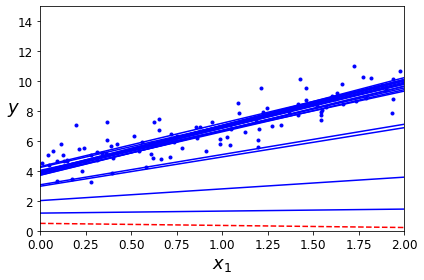

In [18]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                   
            y_predict = X_new_b.dot(theta)          
            style = "b-" if i > 0 else "r--"        
            plt.plot(X_new, y_predict, style)       
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                

plt.plot(X, y, "b.")                                
plt.xlabel("$x_1$", fontsize=18)                    
plt.ylabel("$y$", rotation=0, fontsize=18)          
plt.axis([0, 2, 0, 15])                             
save_fig("sgd_plot")                                
plt.show()                                          

In [19]:
theta

array([[4.21076011],
       [2.74856079]])

- 샘플을 무작위로 선택하기 때문에 어떤 샘플은 한 epoch에서 여러 번 선택될 수 있고 어떤 샘플은 전혀 선택되지 못할 수도 있음
- epoch마다 모든 샘플을 사용하게 하려면 훈련 세트를 섞은 후 차례대로 하나씩 선택하고 다음 epoch에서 다시 섞는 식의 방법 사용 가능
     - SGDClassifier, SGDRegressor의 방법

In [20]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [21]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### 미니배치 경사 하강법

- 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레디언트 계산
- 행렬 연산에 최적화된 GPU를 사용하면 성능↑
- 미니배치를 어느 정도 크게 하면 SGD보다 덜 불규칙하게 움직임
- SGD보다 최솟값에 더 가까이 도달할 수 있지만 Local minimum에서 빠져나오기는 더 힘들수도 있음

In [22]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [23]:
theta

array([[4.25214635],
       [2.7896408 ]])

In [24]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

그림 저장: gradient_descent_paths_plot


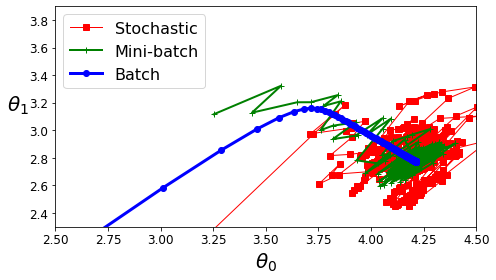

In [25]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

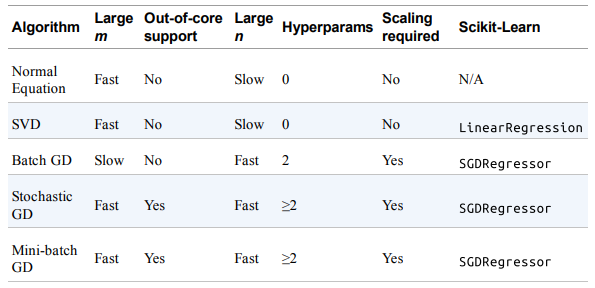

- m : 훈련 샘플 수, n : 특성 수

## 다항 회귀

In [26]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [27]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

그림 저장: quadratic_data_plot


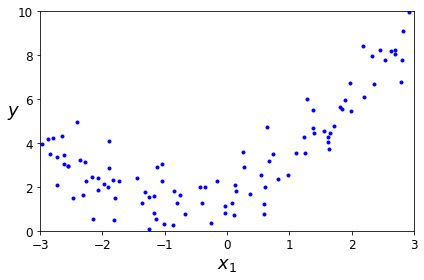

In [28]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [29]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [30]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [31]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

그림 저장: quadratic_predictions_plot


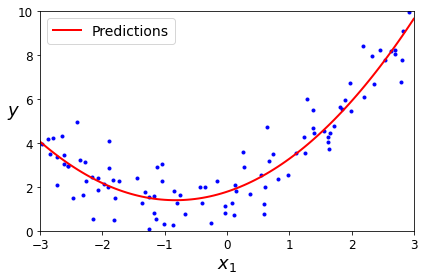

In [32]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

- 원래 함수 : $y = 0.5x_1^2 + 1.0x_1 + 2.0 + α$
- 추정된 함수 : $\hat{y} = 0.56x_1^2 + 0.93x_1 + 1.78$

## 학습 곡선

그림 저장: high_degree_polynomials_plot


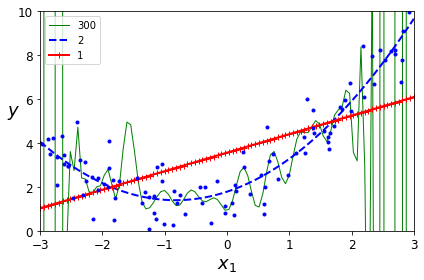

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

- 300차원의 고차 다항 회귀 모델은 심각하게 훈련 데이터에 과대적합됨
- 1차원의 선형 모델은 과소적함임

- 어떻게 모델이 과대적합, 과소적합 되었는지 알 수 있을까?
- 교차 검증
- 훈련 데이터에서 성능이 좋지만 교차 검증 점수가 나쁘다면 과대적합된 것
- 양쪽 모두 좋지 않으면 과소적합

- 학습 곡선 : 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타낸 것
- 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러 번 훈련시키면 됨

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

그림 저장: underfitting_learning_curves_plot


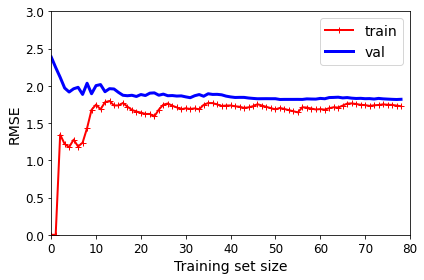

In [35]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         
save_fig("underfitting_learning_curves_plot")   
plt.show()                                      

- 과소적합된 모델
- 훈련 데이터
    - 0에서 시작하므로 훈련 세트에 하나 or 두 개의 샘플이 있을 땐 모델이 완벽하게 작동
    - 훈련 세트에 샘플이 추가됨에 따라 잡음도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습하는 것 불가능
- 검증 데이터
    - 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화될 수 없어 검증 오차가 초기에 매우 큼
    - 모델에 훈련 샘플이 추가됨에 따라 학습 되고 검증 오차 천천히 감소
    - 선형 회귀 직선은 데이터를 잘 모델링할 수 없으므로 오차의 감소가 완만해져서 훈련 세트의 그래프와 가까워짐
- 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해 있음

그림 저장: learning_curves_plot


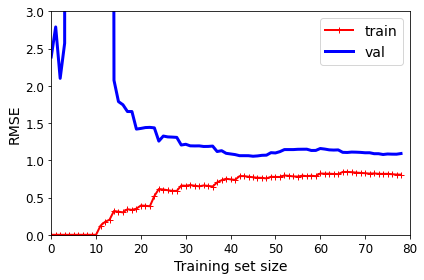

In [36]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           
save_fig("learning_curves_plot")  
plt.show()                        

- 10차 다항 회귀 모델
- 훈련 데이터 오차가 선형 회귀 모델보다 훨씬 낮음
- 두 곡선 사이에 공간이 있음
- 훈련 데이터에서의 모델 성능이 검증 데이터보다 훨씬 낫다는 뜻 = 과대적합 모델 특징
- 그러나 더 큰 훈련 세트 사용하면 두 곡선 점점 가까워짐
- 과대적합 모델 개선하는 방법 중 하나는 검증 오차가 훈련 오차에 근접할 때까지 더 많은 훈련 데이터를 추가하는 것

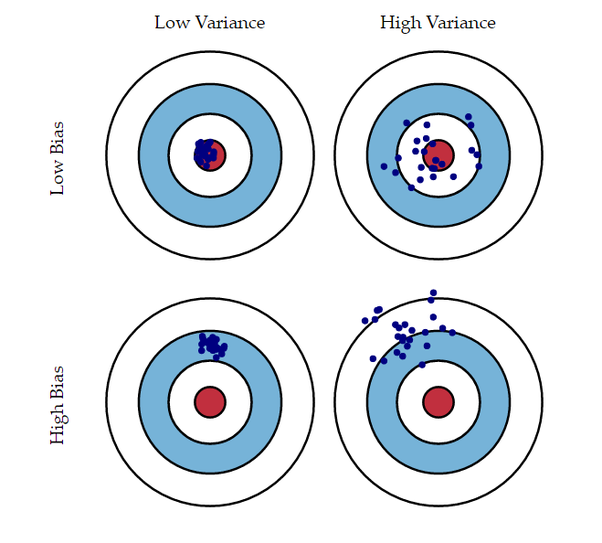

- 모델 복잡도↑ : 분산↑ 편향↓
- 모델 복잡도↓ : 분산↓ 편향↑

## 규제가 있는 선형 모델

- 과대적합을 감소시키는 좋은 방법 = 모델 규제하는 것
- 다항회귀모델 규제 : 다항식 차수 감소
- 선형회귀모델 규제 : 모델 가중치 제한

### 릿지 회귀

**식 4-8: 릿지 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2
$

- 비용함수에 규제항 추가
- 모델의 가중치가 가능한 한 작게 유지되도록
- 규제항은 훈련하는 동안에만 비용 함수에 추가

- 하이퍼파라미터 α : 모델을 얼마나 많이 규제할지 조절
- α가 매우 크면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 됨

- 입력 특성의 스케일에 민감하기 때문에 데이터 스케일 진행 ex StandardScaler

In [37]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [39]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

그림 저장: ridge_regression_plot


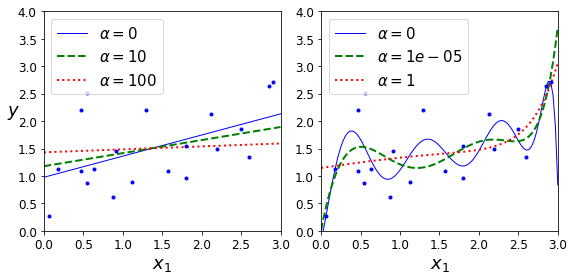

In [40]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

- 왼쪽 그래프 : 평범한 릿지 모델 사용해 선형적인 예측
- 오른쪽 그래프 : PolynomialFeatures(degree=10)을 사용해 먼저 데이터 확장하고 StandardScaler 사용해 스케일 조정 후 릿지 모델 적용

- α가 클수록 직선에 가까워짐

- 릿지 회귀의 정규방정식<br>
$\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X}+α\mathbf{A})^{-1} \mathbf{X}^T \mathbf{y}$

In [38]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

- 확률적 경사 하강법 사용했을 때

In [41]:
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

- penalty : 사용할 규제, l2 = 릿지

### 라쏘 회귀

**식 4-10: 라쏘 회귀의 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right|
$

- 릿지처럼 비용 함수에 규제항 더함

C:\Users\jiddo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827432, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


그림 저장: lasso_regression_plot


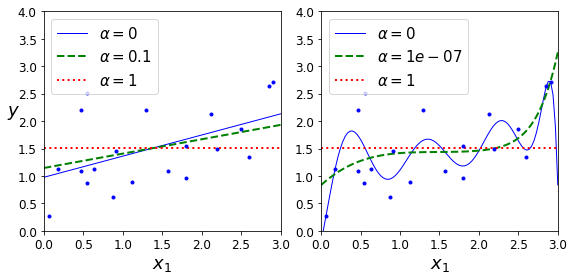

In [42]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

- 덜 중요한 특성의 가중치 제거
- 자동으로 특성 선택 후 희소 모델 만듦

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [52]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

그림 저장: lasso_vs_ridge_plot


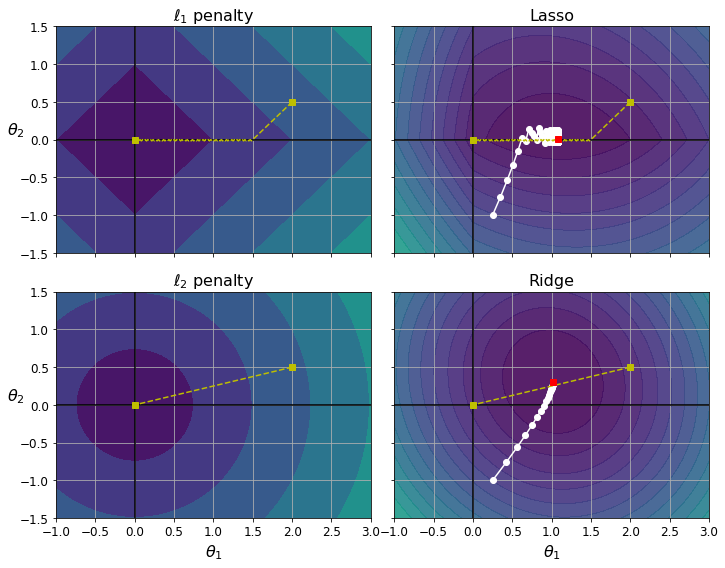

In [53]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()

- 왼쪽 위 그래프의 등고선은 l1 손실
    - 축제 가까워지면서 선형적으로 줄어듦
    - $\theta_2$가 먼저 0에 도달한 뒤 $\theta_1$이 0에 도달
- 오른쪽 위 그래프의 등고선은 라쏘 손실 함수 나타냄
    - α를 증가하면 전역 최적점이 노란 점을 따라 왼쪽으로 이동
- 왼쪽 아래 그래프의 등고선은 l2 손실
    - 원점까지 직선 경로를 따르며 줄어듦
- 오른쪽 아래 그래프의 등고선은 릿지 회귀
    - 파라미터가 전역 최적점에 가까워질수록 그레디언트가 작아짐
    - α를 증가시킬수록 최적의 파라미터가 원점에 더 가까워짐

In [43]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

- Lasso 대신 SGDRegressor(penalty="l1") 사용 가능

### 엘라스틱넷

**식 4-12: 엘라스틱넷 비용 함수**

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$

- 릿지 회귀와 라쏘 회귀 절충한 모델
- 릿지와 라쏘의 규제항을 단순히 더해서 사용하며 혼합 정도는 혼합 비율 $\gamma$를 사용해 조절
- $\gamma=0$이면 릿지 회귀와 같고 $\gamma=1$이면 라쏘 회귀와 같음

- 릿지가 기본이지만 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘나 엘라스틱넷이 남
    - 불필요한 특성의 가중치를 0으로 만들기 때문
- 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 엘라스틱넷 선호

In [45]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

- l1_ratio : $\gamma$

### 조기 종료

- 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것

In [47]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [48]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

그림 저장: early_stopping_plot


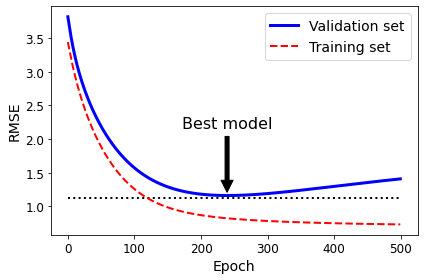

In [49]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [50]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

- 확률적 경사 하강법이나 미니배치 경사 하강법에서는 곡선이 그리 매끄럽지 않아 최솟값에 도달했는지 확인하기 어려움
- 검증 에러가 일정 시간 동안 최솟값보다 클 때 학습 멈추고 검증 에러가 최소였을 때의 모델 파라미터로 되돌리기

## 로지스틱 회귀

- 샘플이 특정 클래스에 속할 확률 추정
- 분류

### 확률 추정

- 입력 특성의 가중치 합 계산 후 편향 더함
- 결괏값의 로지스틱을 출력
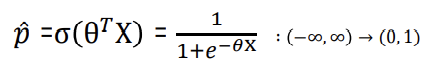

그림 저장: logistic_function_plot


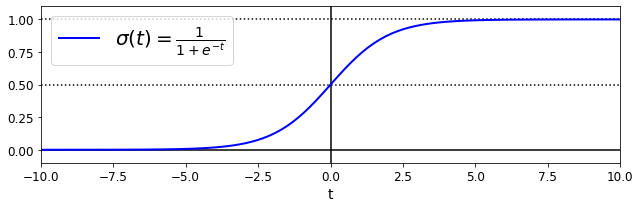

In [3]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

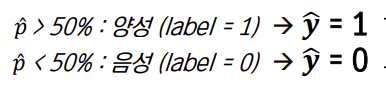

- 훈련의 목적 : 양성 샘플(y=1)에 대해서는 높은 확률 추정, 음성 샘플(y=0)에 대해서는 낮은 확률 추정하는 파라미터 벡터 $\theta$를 찾는 것

$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1, \\
  -\log(1 - \hat{p}) & \text{if } y = 0.
\end{cases}
$

**식 4-17: 로지스틱 회귀 비용 함수(로그 손실)**

$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$


**식 4-18: 로지스틱 비용 함수의 편도 함수**

$
\dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)}
$

### 결정경계

In [4]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(np.int)  # Iris virginica이면 1 아니면 0

In [5]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

그림 저장: logistic_regression_plot


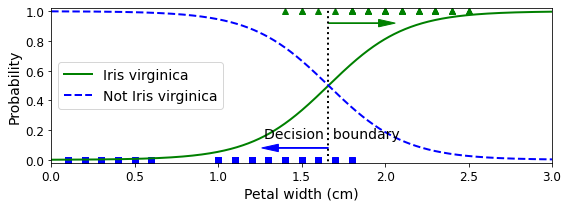

In [7]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]  # 양성 클래스에 대한 확률

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

- 특성이 하나이므로 결정 경계를 만드는 X 값이 1개이다
- 결정 경계가 축에 평행하게 나타난다

그림 저장: logistic_regression_contour_plot


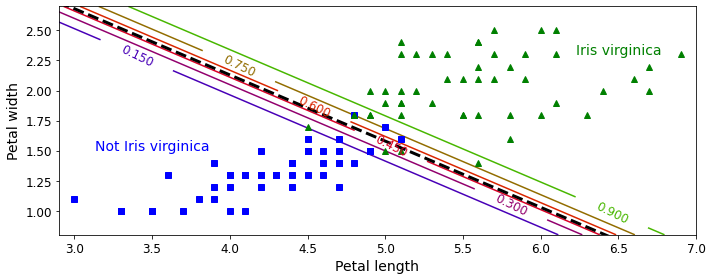

In [8]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width : 특성 2개
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid( # 축에 대한 point를 입력 받고 point들이 교차하는 좌표 모두 계산
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape) # 결정경계
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

- 특성이 2개이므로 결정 경계를 만드는 X값이 2개이다
- 결정 경계가 직선 방정식으로 나타남

### 소프트맥스 회귀
- 다항 로지스틱 회귀

**식 4-20: 소프트맥스 함수**

$
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$
- k : 클래스 수
- s(x) : 샘플 x에 대한 각 클래스의 점수를 담은 벡터
- $\sigma\left(\mathbf{s}(\mathbf{x})\right)_k$ : 샘플 x에 대한 각 클래스의 점수가 주어졌을 때 이 샘플이 클래스 k에 속할 추정 확률


**식 4-22: 크로스 엔트로피 비용 함수**

$
J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$

**식 4-23: 클래스 k에 대한 크로스 엔트로피의 그레이디언트 벡터**

$
\nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$

- 목적 : 모델이 타깃 클래스에 대해 높은 확률을 다른 클래스에 대해 낮은 확률을 추정하도록 만드는 것
- 크로스 엔트로피 비용 함수를 최소화하는 것이 타깃 클래스에 대해 낮은 확률을 예측하는 모델 억제하므로 목적에 부합

In [9]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

그림 저장: softmax_regression_contour_plot


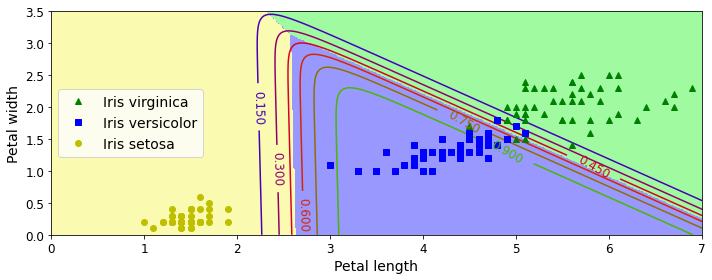

In [10]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()